In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import keras
import cv2

In [2]:
root_path = "./data/"
train_path = root_path + "train"
test_path = root_path + "test"

### a pelo

In [3]:
import os
import cv2
import numpy as np

def read_data(directorio, reshape_dim=(32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir(os.path.join(directorio, folder)):
            for file in os.listdir(os.path.join(directorio, folder)):
                image_path = os.path.join(directorio, folder, file)
                image = cv2.imread(image_path)
                if image is not None:  # Verificar si la imagen se leyó correctamente
                    image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convertimos de BGR a RGB

                    X.append(image)
                    y.append(folder)
                else:
                    print(f"Advertencia: No se pudo leer la imagen correctamente: {image_path}")
    return np.array(X), np.array(y)


In [4]:
X_test, y_test = read_data(test_path, reshape_dim=(128,128))

In [5]:
X_test.shape, y_test.shape

((80, 128, 128, 3), (80,))

In [6]:
X_train, y_train = read_data(train_path, reshape_dim=(128,128))

In [7]:
X_train.shape, y_train.shape

((291, 128, 128, 3), (291,))

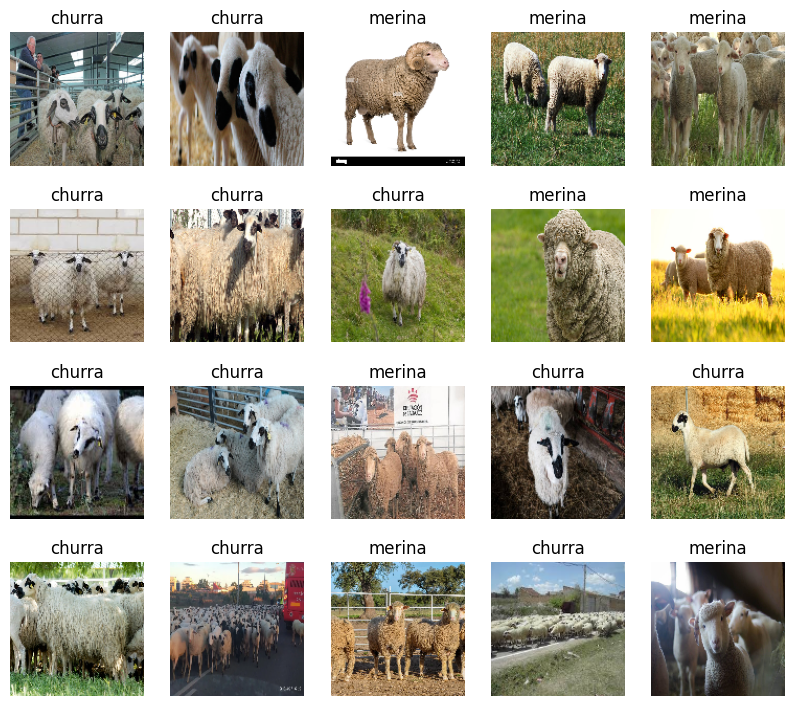

In [8]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])
            
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [9]:
mapa = {"churra":0,
        "merina":1}
inverse_mapping = {0:"churra",
                   1:"merina"}

In [10]:
X_train = X_train / 255
X_test = X_test / 255

In [11]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [12]:
X_train.shape

(291, 128, 128, 3)

In [13]:
capas = [
    keras.layers.Input(shape=(128, 128, 3)),
    keras.layers.Conv2D(filters=30, kernel_size=(3, 3), padding="same", activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=15, kernel_size=(3, 3), padding="same", activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
]

model = keras.Sequential(capas)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 30)   │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       153,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,526 (619.24 KB)

 Trainable params: 158,526 (619.24 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
y_train_num = np.array(pd.Series(y_train).map(mapa))
y_test_num = np.array(pd.Series(y_test).map(mapa))

In [15]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split=.2,
                    epochs=50,
                    batch_size = 32,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5210 - loss: 0.7493 - val_accuracy: 0.4915 - val_loss: 0.6960
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5265 - loss: 0.6891 - val_accuracy: 0.5085 - val_loss: 0.6915
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5477 - loss: 0.6866 - val_accuracy: 0.5254 - val_loss: 0.6915
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6204 - loss: 0.6749 - val_accuracy: 0.5085 - val_loss: 0.6796
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6368 - loss: 0.6503 - val_accuracy: 0.5254 - val_loss: 0.6849
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6589 - loss: 0.6298 - val_accuracy: 0.5763 - val_loss: 0.6742
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7521 - loss: 0.5637 - val_accuracy: 0.5763 - val_loss: 0.7559
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7087 - loss: 0.5620 - val_accuracy: 0.5763 - val_loss: 0.6813

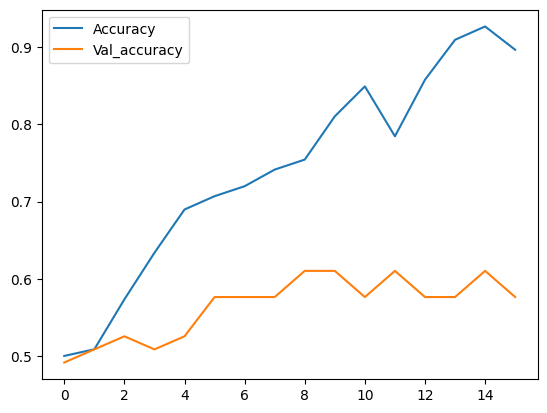

In [16]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

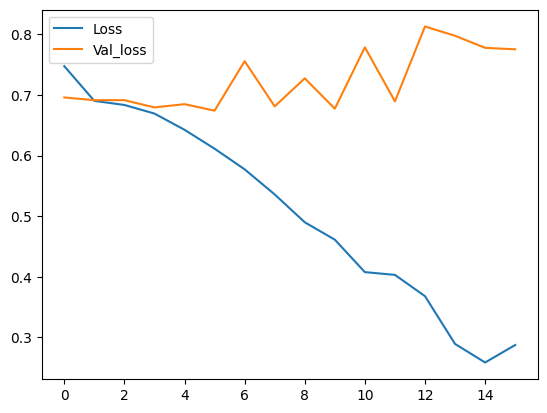

In [17]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

In [18]:
model.evaluate(X_test, y_test_num)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5508 - loss: 0.6938


[0.6811091303825378, 0.5625]

In [19]:
predictions = model.predict(X_test)
y_pred = (predictions > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


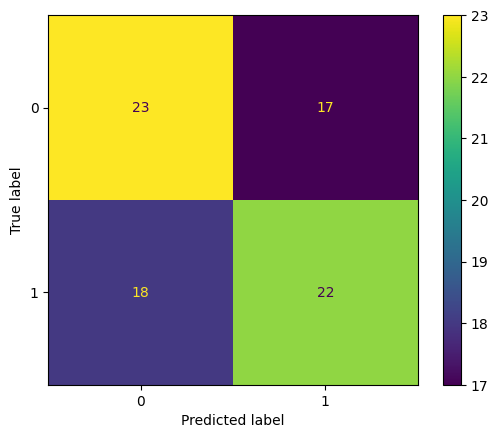

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred)

### image data generator

In [21]:
train_path = "./data/train"  # Suponiendo que este es tu directorio de entrenamiento
directorios = [train_path+"/churra", train_path+"/merina"]
ficheros = []
clases = []

for directorio in directorios:
    clase = directorio.split("/")[-1]  # Obtiene el nombre del directorio como la categoría
    ficheros += [directorio + "/" + fichero for fichero in os.listdir(directorio)]
    clases += [clase for _ in os.listdir(directorio)]

train_augmented = pd.DataFrame({"filename": ficheros, "category": clases})
train_augmented


,filename,category
0,./data/train/churra/0094117D-C6C6-52CF-FD09E61...,churra
1,./data/train/churra/022D5VP4_1.webp,churra
2,./data/train/churra/05-250523-HERMANAMIENTO-CH...,churra
3,./data/train/churra/1000_F_147225458_NevG6mfIE...,churra
4,./data/train/churra/1000_F_209537025_VHstcDS0m...,churra
...,...,...
286,./data/train/merina/trashumancia_madrid_14_01....,merina
287,./data/train/merina/trasterminancia-6.jpeg,merina
288,./data/train/merina/una-oveja-merina-de-pie-en...,merina
289,./data/train/merina/unnamed.jpg,merina


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

example_df = train_augmented.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15, # Angulo de rotación
    rescale=1./255, # Escalado, ya nos escala las imágenes
    shear_range=0.1, # Inclina las imágenes, no es giro es inclinación como hacerlas "cursivas"
    zoom_range=0.2, # Zoom
    horizontal_flip=True, # giro horizontal o especular
    width_shift_range=0.1, # Desplazamiento horizontal de los pixeles
    height_shift_range=0.1 # Desplazamiento vertical de los píxeles
)


example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
)

Found 1 validated image filenames belonging to 1 classes.


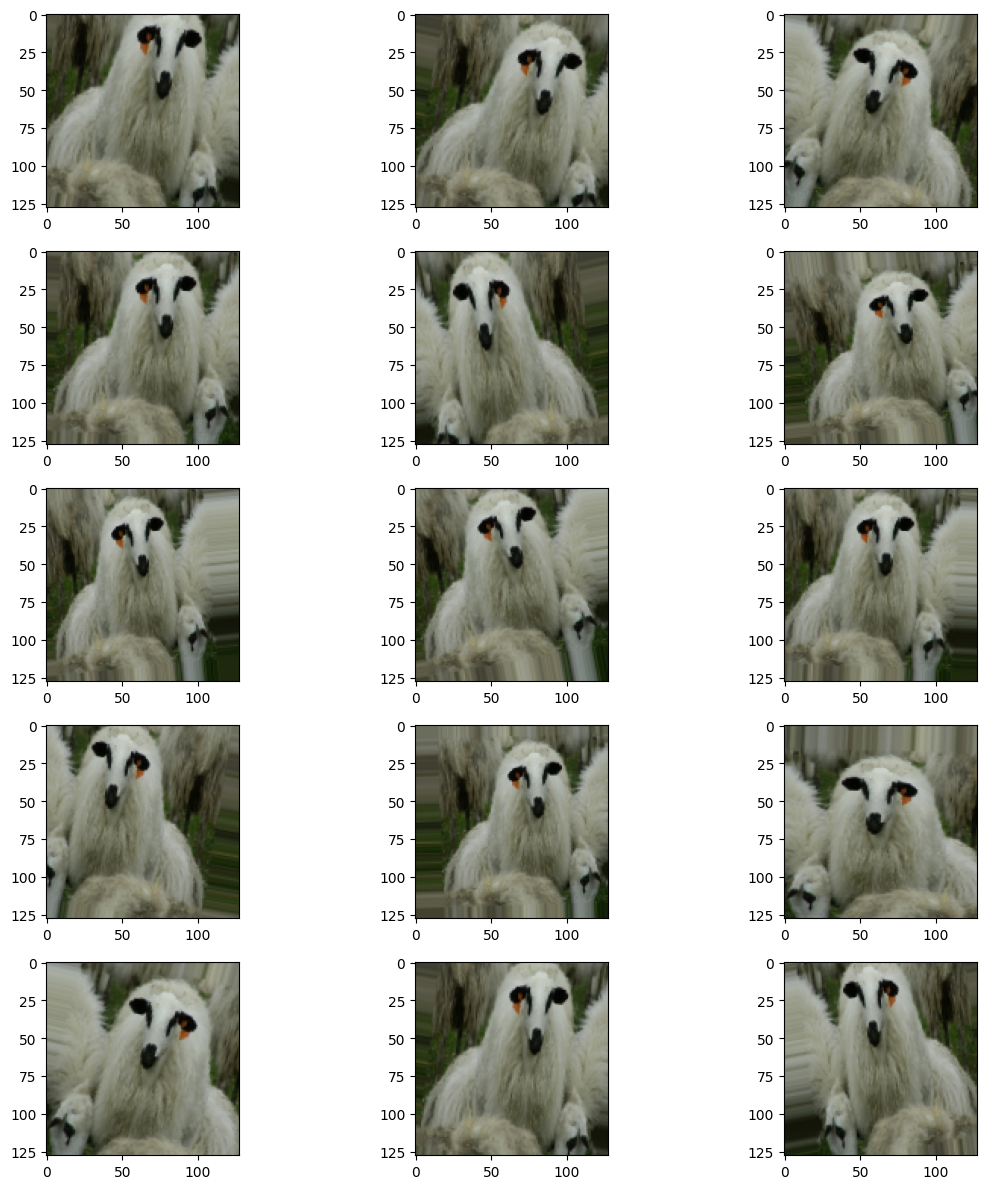

In [23]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(train_augmented,
                                         test_size=0.20,
                                         random_state=42)

In [25]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [26]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 232
Shape validation 59


,filename,category
0,./data/train/churra/images (11).jpg,churra
1,./data/train/merina/merina_u.jpg,merina
2,./data/train/churra/ch 02_xoptimizadax--575x32...,churra
3,./data/train/merina/8_Foto.jpg,merina
4,./data/train/churra/razas-ovinas-4.webp,churra


In [27]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary', # Porque es binaria, si fuera multiclase y en un sólo valor -> "sparse" (otras configuraciones, ver la documentación)
    batch_size= 32
)

Found 204 validated image filenames belonging to 2 classes.


c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 28 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [28]:
validation_datagen = ImageDataGenerator(rescale=1./255) # Solo vamos a reescalar
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size= 32
)

Found 55 validated image filenames belonging to 2 classes.


c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [29]:
model = keras.Sequential(capas)

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
history = model.fit(
    train_generator, 
    epochs= 100,
    validation_data=validation_generator,
    callbacks= [keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)]
)

Epoch 1/100


c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/7 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6562 - loss: 0.6479

c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5882 - loss: 0.6912 - val_accuracy: 0.7818 - val_loss: 0.6027
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6428 - loss: 0.6588 - val_accuracy: 0.6909 - val_loss: 0.6139
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6292 - loss: 0.6545 - val_accuracy: 0.7455 - val_loss: 0.5779
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5691 - loss: 0.6682 - val_accuracy: 0.7455 - val_loss: 0.5750
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.6689 - loss: 0.6385 - val_accuracy: 0.7455 - val_loss: 0.5549
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.6734 - loss: 0.6288 - val_accuracy: 0.6909 - val_loss: 0.5573
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.6456 - loss: 0.6140 - val_accuracy: 0.7091 - val_loss: 0.5526
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6804 - loss: 0.5932 - val_accuracy: 0.7091 - val_loss: 0.5

In [31]:
results = model.evaluate(X_test, y_test_num)
print("test loss, test acc:", results)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6445 - loss: 0.6924 
test loss, test acc: [0.7092419266700745, 0.625]


### transfer learning

In [40]:
from keras.applications import MobileNetV2
from keras import layers, Model

base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model=base_model):
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(rate=.50)(x)

    x = layers.Dense((pd.Series(y_train).nunique()), activation="softmax")(x)

    model = Model(base_model.input,x)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    
    return model

model = prepare_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,913,442 (11.11 MB)

 Trainable params: 655,458 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [41]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [42]:
model = prepare_model()
history = model.fit(X_train, y_train_num,
                    batch_size = 16,
                    validation_split = .2,
                    epochs = 100,
                    callbacks = [early_stopping])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - acc: 0.6419 - loss: 1.6704 - val_acc: 0.7458 - val_loss: 0.7214
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.8524 - loss: 0.3770 - val_acc: 0.8475 - val_loss: 0.2874
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.9160 - loss: 0.2127 - val_acc: 0.8983 - val_loss: 0.2905
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - acc: 0.9424 - loss: 0.1450 - val_acc: 0.9153 - val_loss: 0.1992
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - acc: 0.9510 - loss: 0.1657 - val_acc: 0.9153 - val_loss: 0.2888
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - acc: 0.8952 - loss: 0.1835 - val_acc: 0.8814 - val_loss: 0.5749
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - acc: 0.9356 - loss: 0.1353 - val_acc: 0.9322 - val_loss: 0.3192
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - acc: 0.9821 - loss: 0.0867 - val_acc: 0.8814 - val_loss: 0.2964
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - a

In [43]:
model.evaluate(X_test, y_test_num)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - acc: 0.9273 - loss: 0.1854


[0.20357012748718262, 0.925000011920929]

In [51]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
              precision    recall  f1-score   support

      churra       0.97      0.88      0.92        40
      merina       0.89      0.97      0.93        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80



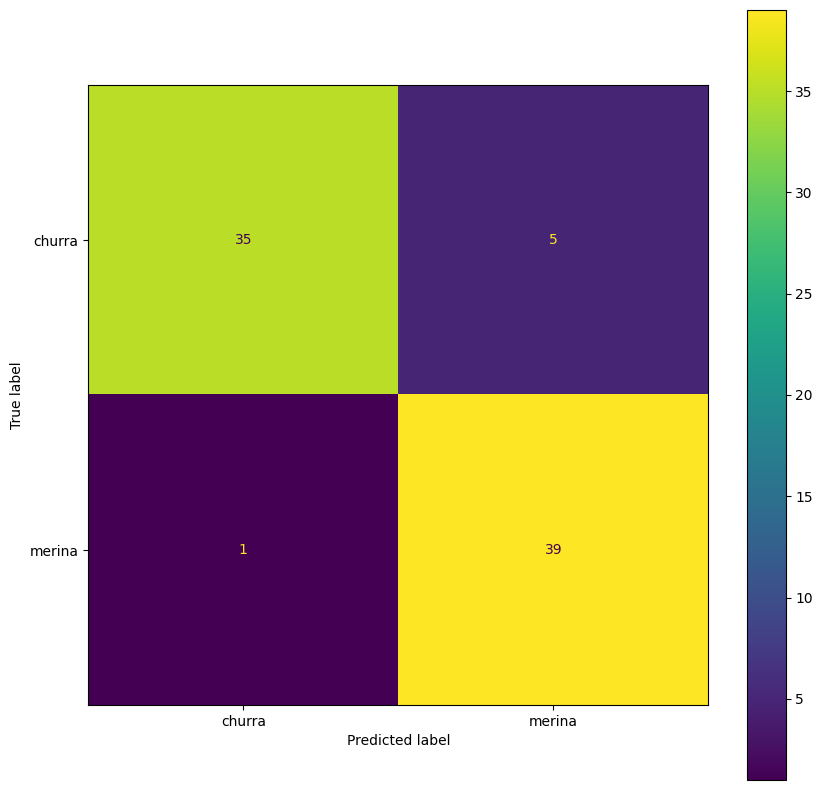

In [52]:
fig,axs = plt.subplots(1,1,figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = axs)